## Loading the Libraries and Dataset

In [78]:
# If we want to run each section or not
VIZU = True
TRAIN_TEST = False
SUBMIT = True

In [79]:
import pandas as pd
import numpy as np
import time

In [80]:
# Importing dataset
folder_path = "dataset/"
train_x_file = "AMF_train_X_XCZw8r3.csv"
train_y_file = "AMF_train_Y_omYQJZL.csv"
test_x_file = "AMF_test_X_uDs0jHH.csv"
train_X = pd.read_csv(folder_path + train_x_file)
train_y = pd.read_csv(folder_path + train_y_file)
test_X = pd.read_csv(folder_path + test_x_file)

In [81]:
# Merging train data X and y
train_df = train_X.merge(train_y, on='Trader')

## Some visualization

In [82]:
train_df.head(5)

Index    Share      Day     Trader       OTR        OCR         OMR  \
0      1   Isin_8  Date_24  Trader_10  2.272727   8.333333   12.500000   
1      2  Isin_87  Date_29  Trader_10  1.696629  25.166667   21.571429   
2      3  Isin_87  Date_23  Trader_10  1.482759  47.300000  118.250000   
3      4  Isin_12  Date_11  Trader_10  1.705882  14.500000   29.000000   
4      5  Isin_87   Date_9  Trader_10  1.517730  26.750000         NaN   

   min_time_two_events  mean_time_two_events  10_p_time_two_events  ...  \
0                  0.0           5117.830300              0.000000  ...   
1                  0.0           1846.968401              0.000074  ...   
2                  0.0            686.300630              0.000071  ...   
3                  0.0           2174.335265              0.000000  ...   
4                  0.0            944.008551              0.000071  ...   

   mean_dt_TV1_TV2  med_dt_TV1_TV2  min_dt_TV1_TV3  mean_dt_TV1_TV3  \
0              NaN             NaN             NaN              NaN   
1              NaN             NaN             NaN              NaN   
2              NaN             NaN             NaN              NaN   
3              NaN             NaN             NaN              NaN   
4              NaN             NaN             NaN              NaN   

   med_dt_TV1_TV3  min_dt_TV1_TV4  mean_dt_TV1_TV4  med_dt_TV1_TV4  \
0             NaN             NaN              NaN             NaN   
1             NaN             NaN              NaN             NaN   
2             NaN             NaN              NaN             NaN   
3             NaN             NaN              NaN             NaN   
4             NaN             NaN              NaN             NaN   

   NbSecondWithAtLeatOneTrade     type  
0                           4  NON HFT  
1                          15  NON HFT  
2                          63  NON HFT  
3                           4  NON HFT  
4                          38  NON HFT  

[5 rows x 40 columns]

In [83]:
train_df.info(), train_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105782 entries, 0 to 105781
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Index                       105782 non-null  int64  
 1   Share                       105782 non-null  object 
 2   Day                         105782 non-null  object 
 3   Trader                      105782 non-null  object 
 4   OTR                         104099 non-null  float64
 5   OCR                         105782 non-null  float64
 6   OMR                         58170 non-null   float64
 7   min_time_two_events         105782 non-null  float64
 8   mean_time_two_events        105782 non-null  float64
 9   10_p_time_two_events        105782 non-null  float64
 10  med_time_two_events         105782 non-null  float64
 11  25_p_time_two_events        105782 non-null  float64
 12  75_p_time_two_events        105782 non-null  float64
 13  90_p_time_two_

(None, (105782, 40))

In [84]:
np.unique(train_df['type'], return_counts=True)

(array(['HFT', 'MIX', 'NON HFT'], dtype=object), array([31950, 51483, 22349]))

## Data Preprocessing

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [86]:
# Definition of the preprocessing pipeline 

num_transformer = Pipeline([
                            ('imputer', SimpleImputer(strategy='mean')),
                            ('std_scaler', StandardScaler())
                           ])

features_to_keep = list(train_X.columns)[4:]

preprocess = ColumnTransformer([
                                ('num_transformer',num_transformer,features_to_keep)
                               ])

## LDA as Dimensionnality Reduction

### Projecting in the new feature space

In [87]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = Pipeline([
                ('preprocess', preprocess),
                ('lda', LinearDiscriminantAnalysis())
               ])

In [88]:
# Transforming the data ( projection in the new feature spaceof dimension nb(classes)-1 )
if VIZU:
    
    lda_X = lda.fit_transform(train_X, train_df['type'].values)

    lda_df = pd.DataFrame({'dim_1' : lda_X[:,0],
                           'dim_2' : lda_X[:,1],
                           'class' : train_df['type'].values})

### Visualization of the projection

In [89]:
# Function to encode the class as an int (useful for plots, or other applications)
# lda_df must contain a column 'class' which holds the types (HFT, NON HFT, MIX)

def encode_class(lda_df, inplace=True):
    l = []
    for c in lda_df['class'].values:
        if c=='NON HFT':
            l.append(0)
        elif c=='MIX':
            l.append(1)
        else:
            l.append(2)
    if inplace:
        lda_df['class'] = l
    else:
        lda_df_new = lda_df.copy()
        lda_df_new['class'] = l
        return lda_df_new

In [90]:
# Encoding the type with the function defined above

if VIZU:

    lda_df_plot = encode_class(lda_df, inplace=False)

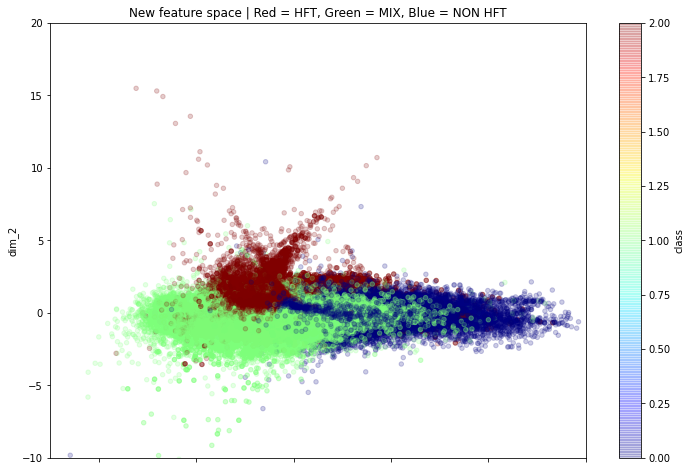

In [91]:
# Plotting the new feature space

if VIZU:

    import matplotlib.pyplot as plt

    lda_df_plot.plot.scatter(x='dim_1', y='dim_2', c='class',
                             alpha=0.2, colormap='jet', 
                             figsize=(12,8), ylim=(-10,20), xlim=(-5,6)
                            )
    plt.title('New feature space | Red = HFT, Green = MIX, Blue = NON HFT')

In [92]:
# Plot helper for displayng subplots

def print_subplots(colors, types, data):
    for i in range(len(types)):
        class_data = lda_df[lda_df['class'] == types[i]]
        class_data.plot.scatter(x='dim_1', y='dim_2', c=colors[i], alpha=0.1, ylim=(-10,20), xlim=(-5,6))
        plt.title(types[i] + ' in new feature space')

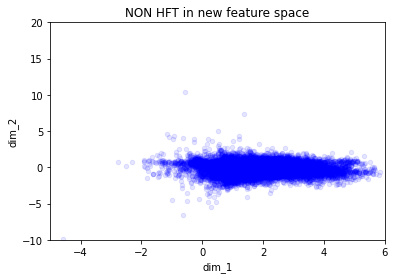

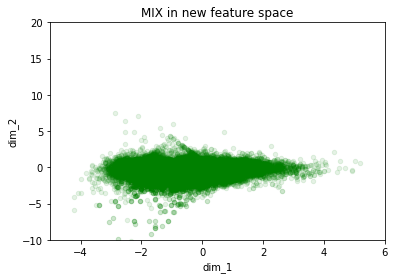

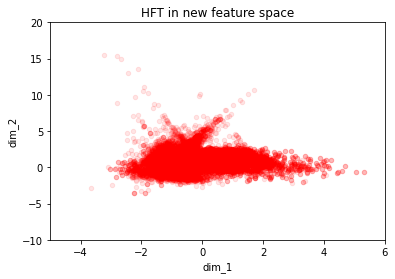

In [93]:
# Plotting each type in different subplots to get a complementary view

if VIZU:

    colors = ['b', 'g', 'r']
    types = ['NON HFT', 'MIX', 'HFT']

    print_subplots(colors, types, lda_df)

## Quick performance test with LDA and QDA as classifiers

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = Pipeline([
                ('preprocess', preprocess),
                ('lda', LinearDiscriminantAnalysis())
               ])

qda = Pipeline([
                ('preprocess', preprocess),
                ('qda', QuadraticDiscriminantAnalysis())
               ])

In [95]:
# Spliting dataset into train and test sets

from sklearn.model_selection import GroupShuffleSplit

gs = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
train_ix, test_ix = next(gs.split(train_X, train_df['type'], groups=train_X.Trader))

X_train = train_X.loc[train_ix]
y_train = train_df['type'].loc[train_ix]

X_test = train_X.loc[test_ix]
y_test = train_df['type'].loc[test_ix]

### Train

In [96]:
if TRAIN_TEST:
    lda.fit(X_train, y_train)
    qda.fit(X_train, y_train)

### Test

In [97]:
# In this decision fonction : 
## a market player whose at least 85% of his rows are predicted as HFT is an HFT participant,
## a market player whose at least 50% of his rows are predicted as MIX is a MIX participant, 
## otherwise the model considers that the market player is a NON HFT.

# df should contain :
## a column called "Trader"
## a column called "type" which could be the real type or the types predicted for the market player

def decision(df):
    traders_list = np.unique(list(df['Trader']))
    traders_type = []
    for trader in traders_list:
        preds = list(df[df['Trader'] == trader]['type']) 
        non_hft = preds.count('NON HFT')
        mix = preds.count('MIX')
        hft = preds.count('HFT')
        rows = hft + non_hft + mix
        if hft/rows >= 0.85:
            traders_type.append('HFT')
        elif mix/rows >= 0.50:
            traders_type.append('MIX')
        else:
            traders_type.append('NON HFT')
    return pd.DataFrame({'Trader':traders_list, 'type':traders_type})

In [98]:
# Prediction
if TRAIN_TEST:
    y_pred_lda = lda.predict(X_test)
    y_pred_qda = qda.predict(X_test)

In [99]:
# Data

if TRAIN_TEST:

    pred_lda_df = X_test['Trader'].to_frame()
    pred_lda_df['type'] = y_pred_lda

    pred_qda_df = X_test['Trader'].to_frame()
    pred_qda_df['type'] = y_pred_qda

    real_df = X_test['Trader'].to_frame()
    real_df['type'] = y_test

In [100]:
# Getting the final dfs holding the predicted and real types for each trader (1 line per Trader only)
if TRAIN_TEST:
    real_traders = decision(real_df)
    pred_traders_lda = decision(pred_lda_df)
    pred_traders_qda = decision(pred_qda_df)

### Metrics

In [101]:
from sklearn import metrics

def micro_average_f1_score(dataframe_y_true, dataframe_y_pred):
    """
    Args
        dataframe_y_true: Pandas Dataframe
            Dataframe containing the true values of y.
            This dataframe was obtained by reading a csv file with following instruction:
            dataframe_y_true = pd.read_csv(CSV_1_FILE_PATH, index_col=0, sep=',')

        dataframe_y_pred: Pandas Dataframe
            This dataframe was obtained by reading a csv file with following instruction:
            dataframe_y_pred = pd.read_csv(CSV_2_FILE_PATH, index_col=0, sep=',')

    Returns
        score: Float
            The metric evaluated with the two dataframes. This must not be NaN.
    """

    score = metrics.f1_score(dataframe_y_true["type"], dataframe_y_pred["type"], average = "micro")

    return score

In [102]:
if TRAIN_TEST:
    print(' LDA | F1 : ' + str(micro_average_f1_score(real_traders, pred_traders_lda)))
    print(' QDA | F1 : ' + str(micro_average_f1_score(real_traders, pred_traders_qda)))

In [103]:
# LDA | F1 : 0.5384615384615384
# QDA | F1 : 0.34615384615384615

## Train for submission

In [104]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Defining the classifiers
lda_clf = Pipeline([
                ('preprocess', preprocess),
                ('lda', LinearDiscriminantAnalysis())
               ])

qda_clf = Pipeline([
                ('preprocess', preprocess),
                ('qda', QuadraticDiscriminantAnalysis())
               ])

y = train_df['type']

In [105]:
if SUBMIT:
    start_time = time.time()
    lda_clf.fit(train_X, y)
    print("--- %s seconds ---" % (time.time() - start_time))

--- 1.135937213897705 seconds ---


In [106]:
if SUBMIT:
    start_time = time.time()
    qda_clf.fit(train_X, y)
    print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6963493824005127 seconds ---


In [107]:
if SUBMIT:
    pred_y_lda = lda_clf.predict(test_X)
    pred_y_qda = lda_clf.predict(test_X)

In [108]:
if SUBMIT:

    pred_df_lda = test_X['Trader'].to_frame()
    pred_df_lda['type'] = pred_y_lda

    pred_df_qda = test_X['Trader'].to_frame()
    pred_df_qda['type'] = pred_y_qda

In [109]:
if SUBMIT:
    pred_traders_lda = decision(pred_df_lda)
    pred_traders_qda = decision(pred_df_qda)

## Saving results

In [110]:
# Prediction results
if SUBMIT:
    pred_traders_lda.to_csv('submission_files/AMF_test_Y_LDA.csv',index=False)
    pred_traders_qda.to_csv('submission_files/AMF_test_Y_QDA.csv',index=False)

In [111]:
if SUBMIT:    
    
    import pickle

    # Models
    pickle.dump(lda_clf['lda'], open('models/model_LDA', 'wb'))
    pickle.dump(qda_clf['qda'], open('models/model_QDA', 'wb'))